In [10]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
import torchvision.transforms as T
import os
from torch.utils.data import random_split
from PIL import Image
import pandas as pd
import numpy as np
import glob

RANDOM = 1
PERSON = 2

class People(Dataset):
  def __init__(self, root_dir, transform=None, loader=default_loader):
    
    self.image_paths, self.image_labels = self._get_imgs_and_labels(root_dir)
    
    self.transform = transform
    self.loader = loader
    
  def __len__(self):
    return len(self.image_labels)
  
  def __getitem__(self, index):
    image = self.loader(self.image_paths[index])
    label = self.image_labels[index]
    
    if self.transform:
      image = self.transform(image)
  
    return image, torch.tensor(int(label)-1) # Convert labels to tensors, and subtract 1 for convention purposes (to start at 0)
  
  # Helper Functions
  def print_image(self, index):
    img = Image.open(self.image_paths[index])
    
    img.show()

  def _get_imgs_and_labels(self, root_dir):
    image_full_path = []
    labels = []
    
    # Get the people images
    for img_path in glob.glob(os.path.join(root_dir, "People", "*.jpg")):
      image_full_path.append(img_path)
      labels.append(PERSON)
    
    # Get the random images
    for img_path in glob.glob(os.path.join(root_dir, "Random", "*.png")):
      image_full_path.append(img_path)
      labels.append(RANDOM)
      
    return image_full_path, labels


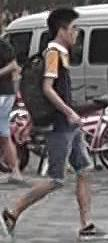

In [11]:
data_dir = "PeopleDataset"

data = People(root_dir=data_dir, transform=T.ToTensor())

data.print_image(1000)

In [65]:
data_dir = "PeopleDataset"

transform = T.Compose ([
  T.Resize((224, 224)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

people_data = People(root_dir=data_dir, transform=transform)

# Use int to round
train_data_size = int(len(people_data) * .8) 
validation_data_size = int(len(people_data) * .2)
other = len(people_data) - (train_data_size + validation_data_size)

train_data, val_data, other2 = random_split(people_data, [train_data_size, validation_data_size, other])

batch_size=32

train = DataLoader(train_data, batch_size=batch_size)
validation = DataLoader(val_data, batch_size=batch_size)

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([32, 3, 224, 224]), torch.Size([32])
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0])

tensor(0)
tensor(1)
tensor(0)


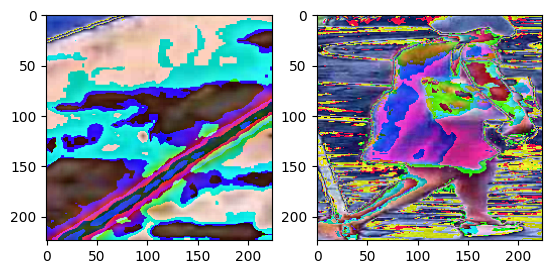

In [66]:
data = iter(train) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

print(single_point[1][0])
print(single_point[1][1])
print(single_point[1][2])

import matplotlib.pyplot as plt
from torchvision import transforms as T
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [68]:
import torch
from torch import nn

class Convolutional(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),                                              
    )
    self.linear = nn.Sequential(nn.Dropout(p=0.5),
                                nn.Linear(in_features=1024, out_features=2048),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(in_features=2048, out_features=2)
                                )
  
  def forward(self, x):
    x = self.conv(x)
    b, c, h, w = x.shape
    x = x.view(b, -1) # Flatten image
    x = self.linear(x)
    
    return x

In [69]:
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
    device2 = torch.device("cpu") # Backup
    print("Using GPU:", torch.cuda.get_device_name(0))
    
else:
    device = torch.device("cpu")
    device2 = torch.device("cpu")
    print("Using CPU")

torch.cuda.empty_cache()
model = Convolutional().to(device)

print(model)

nepochs=25
wd = .0025
learning_rate=1e-1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.65)
LossFunction = nn.CrossEntropyLoss()

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    scheduler.step()
          
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    if (epoch >= epoch - 10): # Save tensor information once we get towards the end
        torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    correct = 0
    total = 0
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in val_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item())
        print(f"Val Acc: {accuracy}%")
            
          

plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Using GPU: NVIDIA GeForce RTX 2070 SUPER
Convolutional(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): D

Epoch:   0%|          | 0/25 [00:00<?, ?epoch/s]

ValueError: not enough values to unpack (expected 4, got 3)